# Understanding $\chi^2$ 2 degrees of freedom noise

In asteroseismology, we tend to work with power-spectra, as opposed to using a timeseries. To get to a power-spectrum, we have to Fourier transform our timeseries (often done with a Lomb-Scargle transform, such as in [lightkurve](https://docs.lightkurve.org/)).

However because nothing can ever be easy, noise that is *Normal distributed in flux*, when Fourier-transformed, becomes *chi-squared two degrees of freedom distributed in power*. In this notebook I'm going to break down:

- what chi-squared two degrees of freedom ($\chi^2_2$ for short) noise looks like
- how to fit a model to it
- what happens to the noise properites when binned
- how to fit a model to the binned data

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import mystyle as ms

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


The equation for $\chi^2_k$ noise for a degrees of freedom $k$ is given by:

\begin{equation}
p(x | k) = \frac{1}{2^{k/2} \Gamma(k/2)}x^{k/2-1}e^{-x/2}
\end{equation}

where $\Gamma$ is the Gamma function, and $x$ here is the *relative space* over which the noise is distributed. Conveniently, the mean of the $\chi^2_k$ distribution is simply $k$, the degrees of freedom.

For $k=2$, we can simplify this equation to:
\begin{equation}
p(x | 2) =\frac{1}{2^{1} \Gamma(1)}x^{1-1}e^{-x/2} \rightarrow \frac{1}{2}e^{-x/2} 
\end{equation}

because conveniently, $\Gamma(1)$ is 1. The mean value of this probability function is 2, which is important to remember.

To see whether this equation accurately describes the noise on a Fourier transformed time-series, let's create some fake white noise and Fourier transform it to check out its properties:

We're going to take the simplest possible case: white noise centered at $0$, with a standard deviation of $1.$.

In [2]:
npts = 10000
sigma = 1.
y = np.random.randn(npts)*sigma
pf = np.abs(np.fft.fft(y))**2
p = pf[int(npts/2):]/(npts/2)

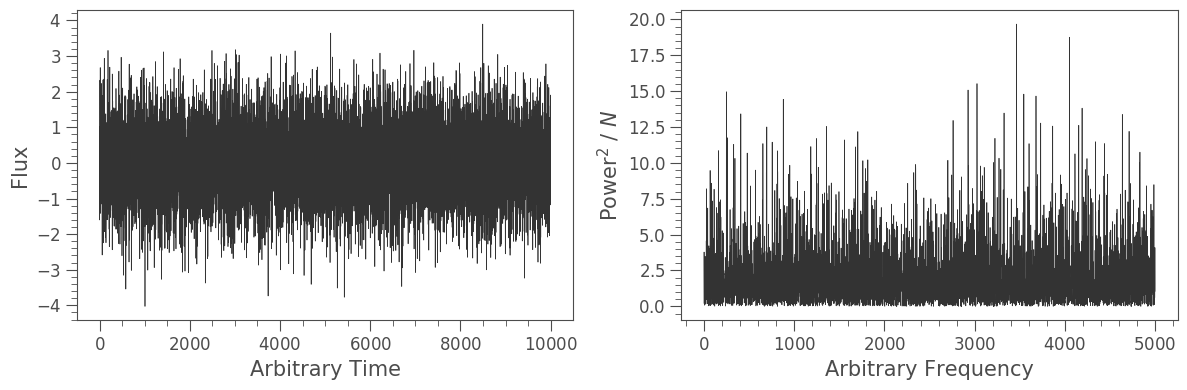

In [3]:
with plt.style.context(ms.ms):
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].plot(y)
    ax[1].plot(p)
    ax[0].set_ylabel('Flux')
    ax[1].set_ylabel(r'Power$^2$ / $N$')
    ax[0].set_xlabel('Arbitrary Time')
    ax[1].set_xlabel('Arbitrary Frequency')
    fig.tight_layout()
    plt.show()

## What is our signal in the frequency domain?

Before we can get onto the noise properties, we need to understand what signal we expect in our power spectrum.

When computing a power spectrum, we are looking at the **mean squared power** of the signal at each frequency. Fortunately, our timeseries data is easy to understand. For normally distributed noise centered at zero with a standard deviation $\sigma$, the mean squared power is simply $\sigma^2$, the variance. For example, for our data:

In [4]:
print('Mean squared power of the data: {:.2f}'.format(np.mean(y**2)))
print('Standard deviation squared: {:.2f}'.format(sigma**2))

Mean squared power of the data: 1.02
Standard deviation squared: 1.00


as expected!

The next step is understanding where this power is concentrated in our power spectrum. Since we are dealing with white noise, the power is equally distributed across *all* frequencies.

So in the absense of noise, our power spectrum should take the value of $\sigma^2$. Lets see if this holds true for our data:

In [5]:
print('Mean of power spectrum: {:.2f}'.format(np.mean(p)))

Mean of power spectrum: 2.04


It looks like the mean of our spectrum is $2\sigma^2$. This is where the $\chi^2_2$ noise comes in.

## What are the noise properties of our data?

$\chi^2_2$ noise is *mulitplicative*, meaning that it appears *relative* to our data. As mentioned above, a particular property of Chi-Squared distributed noise is that it has a mean equal to it's degrees of freedom. In our case, that means $2$.

Because the noise is multiplicative, we can recover the observed mean in our power spectrum by multiplying our signal, $\sigma^2$, with the degrees of freedom, $k$:

In [6]:
print('Mean of power spectrum: {:.2f}'.format(sigma**2 * 2.))

Mean of power spectrum: 2.00


as expected!

To understand how this noise is distributed a bit better, we can plot our data divided through by our known signal to look at its residuals, compared to a $\chi^2_2$ distribution:

In [7]:
signal = sigma**2

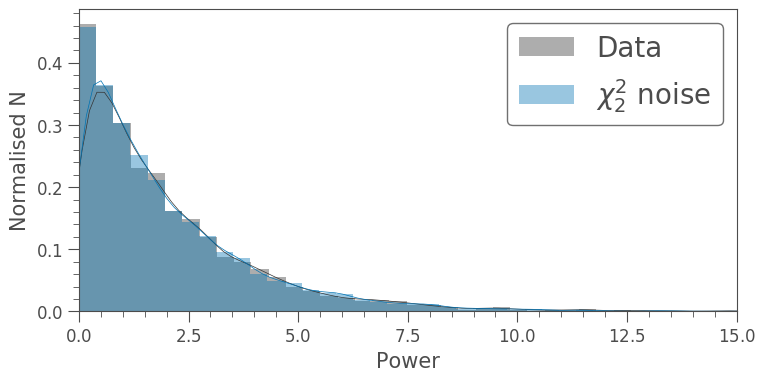

In [8]:
with plt.style.context(ms.ms):
    sns.distplot(p/signal, label='Data')
    sns.distplot(np.random.chisquare(2., size=npts), label=r'$\chi^2_2$ noise')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

As you can see, both line up nicely! The noise on our data is indeed $\chi^2_2$ distributed.

## Fitting a model to the data

### Before we continue...

Since we're now moving on from understaing what $\chi^2_2$ does to our data to actually fitting something to our data, its time to forget about what happened in the time domain. Our signal, in absence of noise, was $\sigma^2$. With the noise present, it is equal to $2\sigma^2$. If we were to fit to measure the background in our power-spectrum, we would be measuring this value of $2\sigma^2$, which is the background.

Of course the noise is applied to the *underlying* value of $\sigma^2$, so we're going to have to insert some factors of two when plotting $\chi^2_2$ distributions further down this blog. This is just an important part of the pain we all have to endure as asteroseismologists. 

In [9]:
background = 2*sigma**2

### Moving on...

As a reminder, the simplified $\chi^2_2$ distribution goes as

\begin{equation}
p(x | 2) = \frac{1}{2}e^{-x/2} \, .
\end{equation}

You might notice that there is no reference to a model here. So how do we fit a model to data?

In practice, in order to describe the $\chi^2_2$ noise properties relative to the signal, we have to rescale the equation so that it becomes a function of the model $M$, so that

\begin{equation}
p(x | k = 2) = \frac{1}{M}e^{-x/M} \, ,
\end{equation}

where $x$ is our observed data.

This is the appropriate likelihood function for fitting a model to some power spectrum data. For more details, see Anderson et al. (1990), Duvall & Harvey (1986), or more modern peakbagging work such as Lund et al. (2017), Davies et al. (2016), Santos et al. (2019) etc.

## Fitting a spectrum in practice

When fitting a model to a power spectrum using a probabilistic programming tool such as [Stan](https://mc-stan.org/) or [PyMC3](https://docs.pymc.io/), it isn't straightforward to model data using a $\chi^2_2$ function, as it doesn't lend well to being applied relative to a model (as we've seen above).

Fortunately, there is a solution. The $\chi^2_k$ distribution is simply a special case of the $\Gamma$ distribution (not to be confused with the $\Gamma$ function!). It goes as follows:

\begin{equation}
p(x | \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)}x^{\alpha-1}e^{-\beta x} .
\end{equation}

We can alreayd see some similarity between this and the $\chi^2_k$ distribution. Using specific values for $\alpha$ and $\beta$, we can directly recover the $\chi^2_2$ distribution relative to a model.

The specific substitions we want to use are $\alpha = k/2$ and $\beta = 1/M$. When substituting these into the above equation we get

\begin{equation}
p(x | \alpha = 1, \beta = 1/M) = \frac{1}{M^1\Gamma(1)}x^{1-1}e^{-x/M} \rightarrow \frac{1}{M}e^{-x/M} ,
\end{equation}

which is the likelihood function we returned above!

Just to showcase how this would work in practice, I've written a quick PyMC3 model to recover the background signal in our power spectrum.

In [10]:
pm_model = pm.Model()
with pm_model:
    back = pm.HalfNormal('back', 100.)
    
    model = tt.ones(len(p)) * back
    
    like = pm.Gamma('like',alpha=1., beta=1./(model), observed=p)
    t_reg = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:03<00:00, 2642.61draws/s]


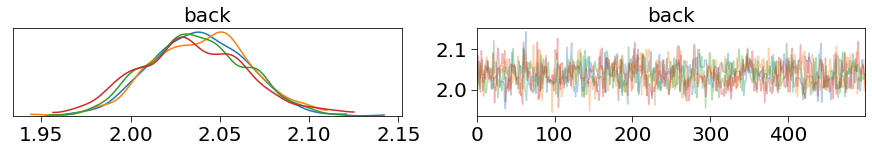

In [11]:
pm.summary(t_reg, var_names=['back']);
pm.traceplot(t_reg, var_names=['back']);

And we can check that we have correctly found the background by dividing the data through our model, and checking the residuals have the noise properties we expect:

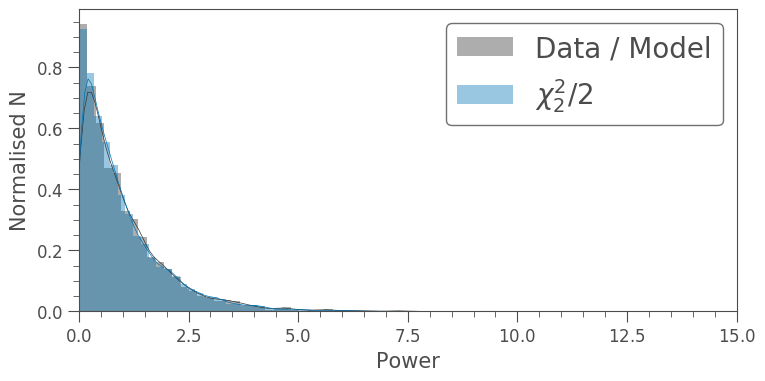

In [12]:
resb = np.median(t_reg['back'])
mod = np.ones(len(p)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(2., size=npts)/2, label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

The noise properties are as we expect them, and we have recovered our "limit spectrum" to high precision! Well done us.

Note: Note that here we're dividing through the $\chi^2_2$ distribution by $2$--- we're plotting the residuals between a model *fit to the power spectrum*, and so its residuals will have a mean $1$, and so we need to center the mean of the $\chi^2_2$ distribution on $1$ as well to compare them.

## Fitting a binned power spectrum

A good asteroseismic power spectrum can be *very* long, and consequently, very computationally heavy to fit a model to. When dealing with fitting artefacts that don't require a high frequency resolution (e.g. the granulation background of a star), binning the data can dramatically reduce the computational cost while having a negligible impact on the inference of a model.

However because we can't have nice things, binning a power spectrum changes its noise properties. Let's investigate how these noise properties change, and how we can still fit a decent model to a binned power spectrum.

We're going to use a binning factor of $b = 5$, meaning that we take 5 bins of power and sum them into a new, single bin, as follows:

In [13]:
b = 5
m = int(len(p)/b)
p_bin = np.sum(p[:m*b].reshape((m, b)),axis=1)

We can see what the distribution of the new binned power looks like compared to our unbinned spectrum:

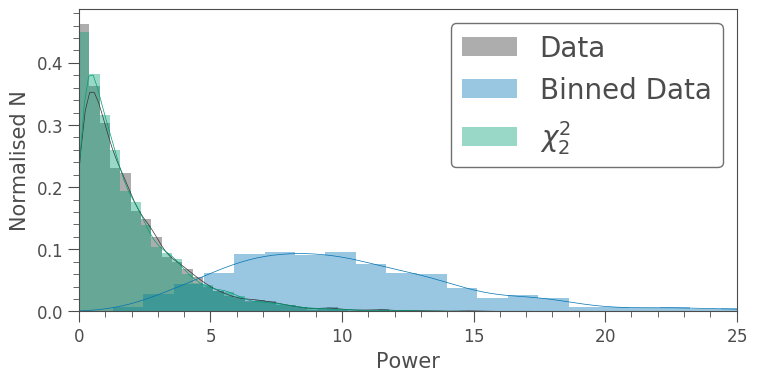

In [14]:
with plt.style.context(ms.ms):
    sns.distplot(p, label='Data')
    sns.distplot(p_bin, label='Binned Data')    
    sns.distplot(np.random.chisquare(2., size=npts), label=r'$\chi^2_2$')
    plt.legend(fontsize=20)
    plt.xlim(0,25)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

In [15]:
print('Mean of the binned data: {:.2f}'.format(np.mean(p_bin)))

Mean of the binned data: 10.18


So it looks like our data has increased in power, and the noise properties have changed from something we previously understood to god knows what.

What if we try performing a fit to the background of these data? We know that our background has a value of $2$, from our previous fit.

In [16]:
pm_model = pm.Model()
with pm_model:
    back = pm.HalfNormal('back', 100.)
    model = tt.ones(len(p_bin)) * back
    
    like = pm.Gamma('like',alpha=1., beta=1./(model), observed=p_bin)
    t_bin = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3376.25draws/s]


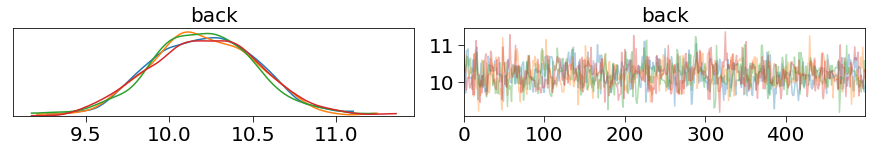

In [17]:
pm.summary(t_bin, var_names=['back']);
pm.traceplot(t_bin, var_names=['back']);

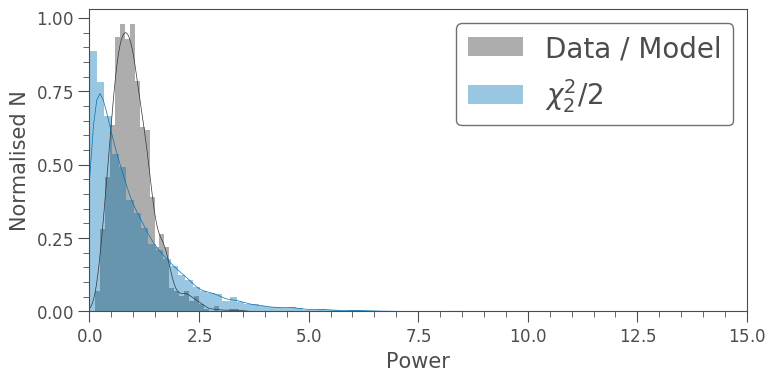

In [18]:
resb = np.median(t_bin['back'])
mod = np.ones(len(p_bin)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(2., size=npts)/2., label=r'$\chi^2_2 / 2$')
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

It looks like the fit mean value is $10$, not $2$, as expected. The residuals, of course, don't look like a $\chi^2_2$ distribution.

Now if we remember, the mean of a $\chi^2_k$ distribution is equal to $k$. The mean of our un-binned power spectrum, with degrees of freedom $k=2$, is $2$. The mean of our binned power spectrum is 10. Could our binned power spectrum follow a $\chi^2_{10}$ distribution?

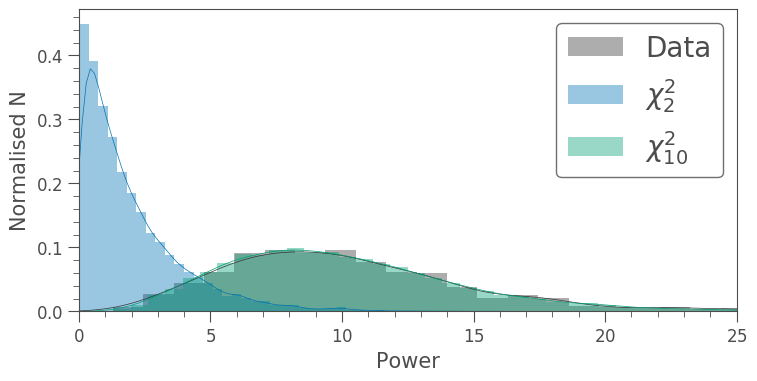

In [19]:
with plt.style.context(ms.ms):
    sns.distplot(p_bin, label='Data')
    sns.distplot(np.random.chisquare(2., size=npts), label=r'$\chi^2_2$')
    sns.distplot(np.random.chisquare(10., size=npts), label=r'$\chi^2_{10}$')    
    plt.legend(fontsize=20)
    plt.xlim(0,25)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

Indeed it is! It's a known property of $\chi^2_2$ noise that when binning over $b$ bins, the noise statistics become $\chi^2_k$ with $k = 2b$ (Appourchaux 2004).

## So how do we model this?

If we remember from earlier, the $\chi^2_2$ distribution, is a special case of the Gamma distribution, which can be evaluated relative to a model by setting the parameters $\alpha = k/2$ and $\beta=1/M$. 

To fit a model to $\chi^2_{10}$ noise, we set $\alpha = 10/2$ when evaluating the Gamma distribution. We can see this by plotting a Gamma distribution with these properties on the above plot:

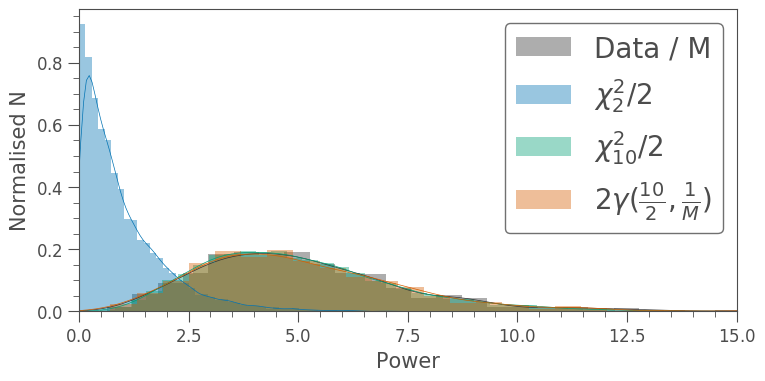

In [20]:
M = np.ones(len(p_bin))*background
with plt.style.context(ms.ms):
    sns.distplot(p_bin/M, label='Data / M')
    sns.distplot(np.random.chisquare(2., size=npts)/2, label=r'$\chi^2_2 / 2$')    
    sns.distplot(np.random.chisquare(10., size=npts)/2, label=r'$\chi^2_{10} / 2$')    
    sns.distplot(np.random.gamma(10./2., 1./M)*2, label=r'$2\gamma(\frac{10}{2}, \frac{1}{M})$')    
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

(Note: I've had to add in a factor of two again--- this is just the difficulty of comparing residuals to noise properties that aren't Gaussian)

And consequently, we can set $\alpha$ to this value when we model our background, and see what happens!

In [21]:
pm_model = pm.Model()
with pm_model:
    back = pm.HalfNormal('back', 100.)
    model = tt.ones(len(p_bin)) * back
    like = pm.Gamma('like',alpha=10./2., beta=1./(model), observed=p_bin)
    t_proper = pm.sample(tune=2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:02<00:00, 3940.36draws/s]


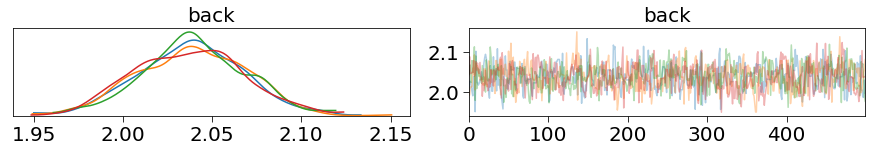

In [22]:
pm.summary(t_proper, var_names=['back']);
pm.traceplot(t_proper, var_names=['back']);

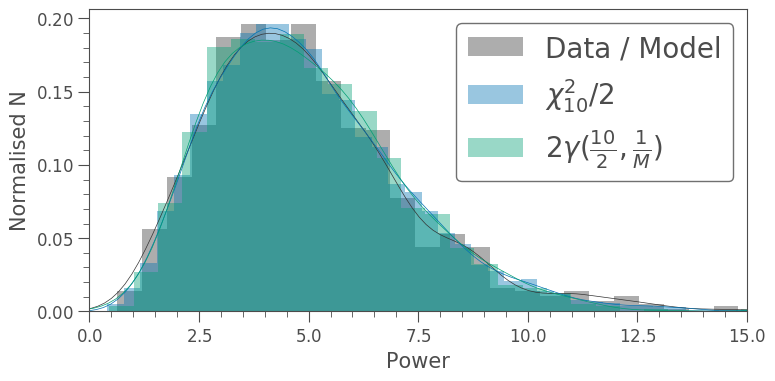

In [23]:
resb = np.median(t_proper['back'])
mod = np.ones(len(p_bin)) * resb

with plt.style.context(ms.ms):
    sns.distplot(p_bin/mod, label='Data / Model')
    sns.distplot(np.random.chisquare(10., size=npts)/2., label=r'$\chi^2_{10} / 2$')
    sns.distplot(np.random.gamma(10./2., 1./mod)*2, label=r'$2\gamma(\frac{10}{2}, \frac{1}{M})$')        
    plt.legend(fontsize=20)
    plt.xlim(0,15)
    plt.xlabel('Power')
    plt.ylabel('Normalised N')

So despite the values in our binned spectrum being *nowhere* near 1, we have succesfully recovered the limit spectrum of our *unbinned* spectrum by properly treating the noise statistics.

Naturally, this applies to any model you try to fit to a power spectrum. Try going through the notebook yourself after adding some signal to the flux, and fitting it in frequency space!